# MILB Team Based Retention Model (QA)

* Stellar Algo
* Nakiska Rad & Ryan Kazmerik
* August 31, 2021

In [2]:
import getpass
import pyodbc
import pandas as pd
import numpy as np

import warnings

from pycaret.classification import *

warnings.filterwarnings('ignore')

## Let's get our dataset from MSSQL. We will select the full season product only and seasons before 2020, since 2020 was a strange year due to covid, and 2021 does not have any repurchasing data available

In [3]:
SERVER = '52.44.171.130' 
DATABASE = 'datascience' 
USERNAME = getpass.getpass(prompt='Enter your username') 
PASSWORD = getpass.getpass(prompt='Enter your password')
CNXN = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER='+SERVER+';DATABASE='+DATABASE+';UID='+USERNAME+';PWD='+ PASSWORD)

Enter your username ············
Enter your password ····················


In [4]:
cursor = CNXN.cursor()

client_id = 11 #bulls
product = "Full Season"
train_season_year = 2019
test_season_year = 2021

query =  f"""
    SELECT 
        r.dimcustomermasterid,
        recency,
        attendancePercent,
        totalSpent,
        distToVenue,
        source_tenure,
        renewedBeforeDays,
        missed_games_1,
        missed_games_2,
        missed_games_over_2,
        isnextyear_buyer
    FROM 
        ds.retentionscoring r 
    WHERE 
        lkupclientid = {client_id} 
    AND 
        productgrouping = {"'"+ str(product) + "'"} 
    AND 
        year < {train_season_year};
    """
    
df = pd.read_sql(query, CNXN)
    
CNXN.commit()
cursor.close()

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1070 entries, 0 to 1069
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   dimcustomermasterid  1070 non-null   object
 1   recency              1070 non-null   int64 
 2   attendancePercent    1070 non-null   object
 3   totalSpent           1070 non-null   object
 4   distToVenue          1070 non-null   object
 5   source_tenure        1070 non-null   int64 
 6   renewedBeforeDays    1070 non-null   int64 
 7   missed_games_1       1070 non-null   int64 
 8   missed_games_2       1070 non-null   int64 
 9   missed_games_over_2  1070 non-null   int64 
 10  isnextyear_buyer     1070 non-null   int64 
dtypes: int64(7), object(4)
memory usage: 92.1+ KB


,dimcustomermasterid,recency,attendancePercent,totalSpent,distToVenue,source_tenure,renewedBeforeDays,missed_games_1,missed_games_2,missed_games_over_2,isnextyear_buyer
0,303661788,0,0.580986,2485,26.49,1460,8,8,8,3,1
1,303663474,1,0.527778,4032,23.92,1460,198,0,2,7,1
2,303659570,0,0.548611,1641.6,24.07,1460,185,14,4,3,1
3,303658983,3,0.313869,1561.8,18.21,1460,197,2,2,3,1
4,303659912,0,0.280992,1379.4,5.16,1460,202,0,0,4,1


## We need to hold back some samples from the dataset for evalution, so let's create the training and evaluation dataset with a hold-back of 10%.

In [5]:
df_train = df.sample(frac=0.9, random_state=786)
df_eval = df.drop(df_train.index)

print('Data for Modeling: ' + str(df_train.shape))
print('Unseen Data For Predictions: ' + str(df_eval.shape))

Data for Modeling: (963, 11)
Unseen Data For Predictions: (107, 11)


## Now we can model the data using PyCaret, with a binary classification prediction for the isnextyear_buyer field to see how likely a customer is to re-purchase.

In [6]:
model = setup(df_train, target='isnextyear_buyer', train_size = 0.8)

,Description,Value
0,session_id,1129
1,Target,isnextyear_buyer
2,Target Type,Binary
3,Label Encoded,"0: 0, 1: 1"
4,Original Data,"(963, 11)"
5,Missing Values,False
6,Numeric Features,4
7,Categorical Features,6
8,Ordinal Features,False
9,High Cardinality Features,False


In [10]:
get_config('X_train').columns

Index(['dimcustomermasterid', 'recency', 'source_tenure', 'renewedBeforeDays',
       'attendancePercent_0', 'attendancePercent_0.0142857',
       'attendancePercent_0.0214286', 'attendancePercent_0.0277778',
       'attendancePercent_0.028169', 'attendancePercent_0.0285714',
       ...
       'missed_games_over_2_10', 'missed_games_over_2_11',
       'missed_games_over_2_2', 'missed_games_over_2_3',
       'missed_games_over_2_4', 'missed_games_over_2_5',
       'missed_games_over_2_6', 'missed_games_over_2_7',
       'missed_games_over_2_8', 'missed_games_over_2_9'],
      dtype='object', length=820)

## Now we can compare all models to evaluate performance. This function trains all models in the model library and scores them using k-fold cross validation for metric evaluation. The output prints a score grid that shows average MAE, MSE, RMSE, R2, RMSLE and MAPE accross the folds (10 by default) along with training time.

In [6]:
model_matrix = compare_models(fold=10, sort="F1")

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.7844,0.7855,0.9615,0.7419,0.8370,0.5342,0.5766,0.1250
rf,Random Forest Classifier,0.7519,0.7748,0.9299,0.7203,0.8114,0.4656,0.5013,0.1590
nb,Naive Bayes,0.7312,0.7508,0.9932,0.6835,0.8095,0.4024,0.4952,0.0270
lightgbm,Light Gradient Boosting Machine,0.7390,0.7909,0.8440,0.7403,0.7878,0.4525,0.4611,0.6300
ada,Ada Boost Classifier,0.7338,0.7420,0.8485,0.7328,0.7856,0.4392,0.4496,0.0700
xgboost,Extreme Gradient Boosting,0.7325,0.7996,0.8125,0.7465,0.7771,0.4442,0.4484,0.7470
dt,Decision Tree Classifier,0.7299,0.7173,0.8031,0.7474,0.7733,0.4399,0.4433,0.0250
et,Extra Trees Classifier,0.6987,0.7490,0.8351,0.7007,0.7607,0.3620,0.3751,0.1560
knn,K Neighbors Classifier,0.6688,0.6876,0.8236,0.6739,0.7408,0.2950,0.3069,0.1990
lr,Logistic Regression,0.5740,0.2918,1.0000,0.5740,0.7294,0.0000,0.0000,0.4440


## Now we can create the best model based on performance and train and evaluate the model. The output prints a score grid that shows MAE, MSE, RMSE, R2, RMSLE and MAPE by fold which by default is set to 10.

In [7]:
best_model = create_model(model_matrix)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8182,0.7738,0.9545,0.7778,0.8571,0.6142,0.6389
1,0.7662,0.8182,0.9545,0.7241,0.8235,0.4960,0.5392
2,0.7143,0.7028,0.9773,0.6719,0.7963,0.3689,0.4504
3,0.7662,0.7545,0.9545,0.7241,0.8235,0.4960,0.5392
4,0.8182,0.8402,0.9773,0.7679,0.8600,0.6111,0.6482
5,0.7792,0.8237,0.9773,0.7288,0.8350,0.5221,0.5758
6,0.8182,0.7972,0.9545,0.7778,0.8571,0.6142,0.6389
7,0.7792,0.8113,0.9091,0.7547,0.8247,0.5333,0.5504
8,0.8052,0.7840,0.9778,0.7586,0.8544,0.5740,0.6176
9,0.7792,0.7497,0.9778,0.7333,0.8381,0.5125,0.5677


In [22]:
type(best_model)

sklearn.ensemble._gb.GradientBoostingClassifier

## Now let's tune the model. In order to tune hyperparameters, the tune_model function is used. This function automatically tunes the hyperparameters of a model using Random Grid Search on a pre-defined search space. The output prints a score grid that shows MAE, MSE, RMSE, R2, RMSLE and MAPE by fold.

In [11]:
tuned_model = tune_model(best_model, optimize = 'F1')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8052,0.8051,0.9545,0.7636,0.8485,0.5850,0.6141
1,0.7792,0.8113,0.9545,0.7368,0.8317,0.5259,0.5643
2,0.7013,0.6722,0.9318,0.6721,0.7810,0.3482,0.3973
3,0.7662,0.7941,0.9091,0.7407,0.8163,0.5039,0.5242
4,0.7792,0.7865,0.9091,0.7547,0.8247,0.5333,0.5504
5,0.7273,0.8278,0.9318,0.6949,0.7961,0.4096,0.4518
6,0.7532,0.8182,0.8864,0.7358,0.8041,0.4784,0.4937
7,0.7662,0.8264,0.8636,0.7600,0.8085,0.5116,0.5185
8,0.7532,0.7965,0.8444,0.7600,0.8000,0.4803,0.4848
9,0.7532,0.7917,0.8889,0.7407,0.8081,0.4705,0.4860


## Let's plot the feature importance. The plot_model() function can be used to analyze the  feature Importance etc. This function takes a trained model object and returns a plot based on the test / hold-out set.

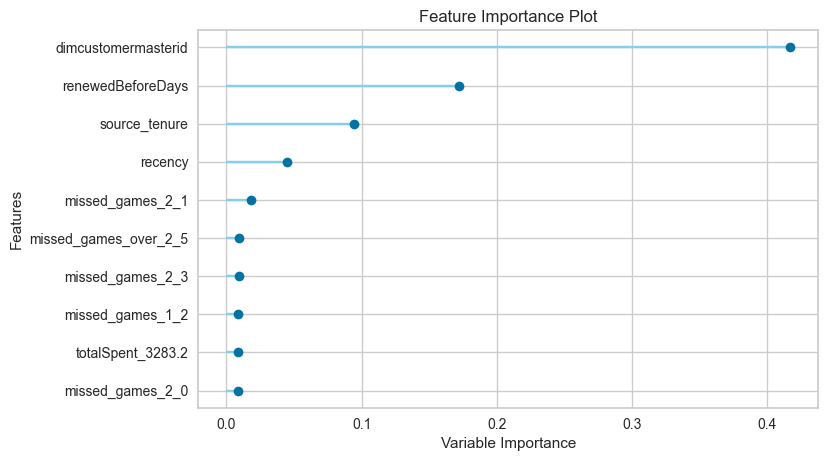

In [12]:
plot_model(tuned_model, plot='feature')

## Now we can predict on the test / evaluation sample. Before finalizing the model, it is advisable to perform one final check by predicting the test/evaluation set and reviewing the evaluation metrics.

In [19]:
predict_model(tuned_model)

unseen_predictions = predict_model(tuned_model, data=df_eval)
unseen_predictions.head()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Gradient Boosting Classifier,0.7824,0.7946,0.9008,0.8027,0.8489,0.4646,0.4746


,dimcustomermasterid,recency,attendancePercent,totalSpent,distToVenue,source_tenure,renewedBeforeDays,missed_games_1,missed_games_2,missed_games_over_2,isnextyear_buyer,Label,Score
3,303658983,3,0.313869,1561.8,18.21,1460,197,2,2,3,1,1,0.7825
5,272911264,0,0.378472,2088,4.02,1460,23,3,2,7,1,1,0.9032
13,272869206,0,0.367816,761.25,75.91,305,160,1,1,5,1,0,0.9098
17,272872610,3,0.104167,1152,29.3,294,149,0,0,2,1,0,0.9206
48,272820865,0,0.722222,1152,42.92,362,217,11,1,3,1,0,0.6248


## Let's finalize the model for deployment. The finalize_model() function fits the model onto the complete dataset including the test/evaluation sample (10% in this case). The purpose of this function is to train the model on the complete dataset before it is deployed in production.

In [24]:
final_model = finalize_model(tuned_model)

<class 'sklearn.ensemble._gb.GradientBoostingClassifier'>


## We can now save the final model. PyCaret's inbuilt function save_model() allows you to save the model along with entire transformation pipeline for later use.

In [29]:
save_model(final_model,'../models/QA-MILB-Team-Based-Retention-Model')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=True, features_todrop=[],
                                       id_columns=[],
                                       ml_usecase='classification',
                                       numerical_features=[],
                                       target='isnextyear_buyer',
                                       time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None,
                                 fill_value_numerical=None,
                                 num...
                                             learning_rate=0.01, loss='deviance',
                                             max_depth=9, max_features=1.0,
                                             max_leaf_nodes=None,
           

## Now that we have an exported model we can use it to score new data. To load a saved model at a future date in the same or an alternative environment, we would use PyCaret's load_model() function and then easily apply the saved model on new unseen data for prediction.

In [30]:
saved_final_model = load_model('../models/QA-MILB-Team-Based-Retention-Model')

new_prediction = predict_model(saved_final_model, data=df_eval)
new_prediction.head()

Transformation Pipeline and Model Successfully Loaded


,dimcustomermasterid,recency,attendancePercent,totalSpent,distToVenue,source_tenure,renewedBeforeDays,missed_games_1,missed_games_2,missed_games_over_2,isnextyear_buyer,Label,Score
3,303658983,3,0.313869,1561.8,18.21,1460,197,2,2,3,1,1,0.8282
5,272911264,0,0.378472,2088,4.02,1460,23,3,2,7,1,1,0.8697
13,272869206,0,0.367816,761.25,75.91,305,160,1,1,5,1,0,0.8796
17,272872610,3,0.104167,1152,29.3,294,149,0,0,2,1,0,0.8328
48,272820865,0,0.722222,1152,42.92,362,217,11,1,3,1,1,0.5935


In [35]:
saved_final_model._final_estimator.feature_importances_

array([4.34028065e-01, 4.42733004e-02, 8.76080050e-02, 1.72641730e-01,
       1.19909393e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 1.73947796e-04, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 4.51990182e-05, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.05166181e-04,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

## FIN!!